In [2]:
import astra
from astra import create_proj_geom
import numpy as np

det_width = 120
det_count = 560
angles = np.linspace(0,2*np.pi, 721)
source_origin = 410.66
origin_det = 143.08
proj_geom = create_proj_geom('fanflat', det_width, det_count, angles, source_origin, origin_det)
print(proj_geom)

{'type': 'fanflat', 'DetectorWidth': 120, 'DetectorCount': 560, 'ProjectionAngles': array([0.        , 0.00872665, 0.01745329, 0.02617994, 0.03490659,
       0.04363323, 0.05235988, 0.06108652, 0.06981317, 0.07853982,
       0.08726646, 0.09599311, 0.10471976, 0.1134464 , 0.12217305,
       0.13089969, 0.13962634, 0.14835299, 0.15707963, 0.16580628,
       0.17453293, 0.18325957, 0.19198622, 0.20071286, 0.20943951,
       0.21816616, 0.2268928 , 0.23561945, 0.2443461 , 0.25307274,
       0.26179939, 0.27052603, 0.27925268, 0.28797933, 0.29670597,
       0.30543262, 0.31415927, 0.32288591, 0.33161256, 0.3403392 ,
       0.34906585, 0.3577925 , 0.36651914, 0.37524579, 0.38397244,
       0.39269908, 0.40142573, 0.41015237, 0.41887902, 0.42760567,
       0.43633231, 0.44505896, 0.45378561, 0.46251225, 0.4712389 ,
       0.47996554, 0.48869219, 0.49741884, 0.50614548, 0.51487213,
       0.52359878, 0.53232542, 0.54105207, 0.54977871, 0.55850536,
       0.56723201, 0.57595865, 0.5846853 , 0.

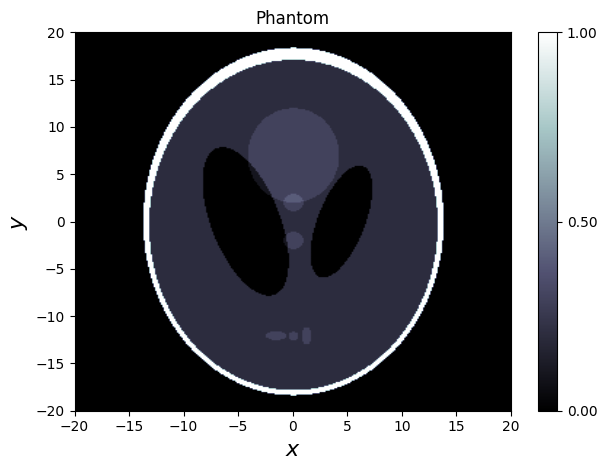

<Figure size 640x480 with 0 Axes>

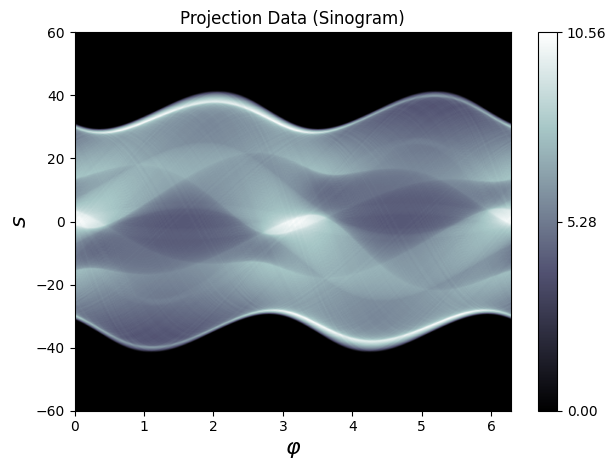

<Figure size 640x480 with 0 Axes>

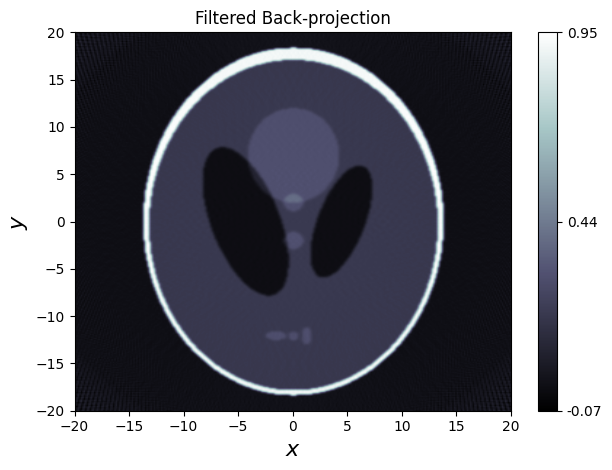

<Figure size 640x480 with 0 Axes>

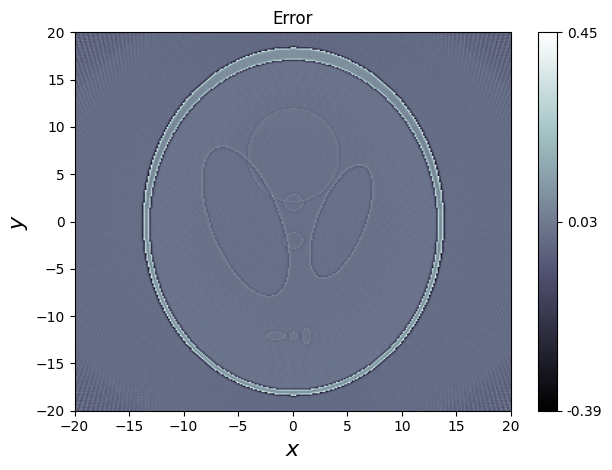

<Figure size 640x480 with 0 Axes>

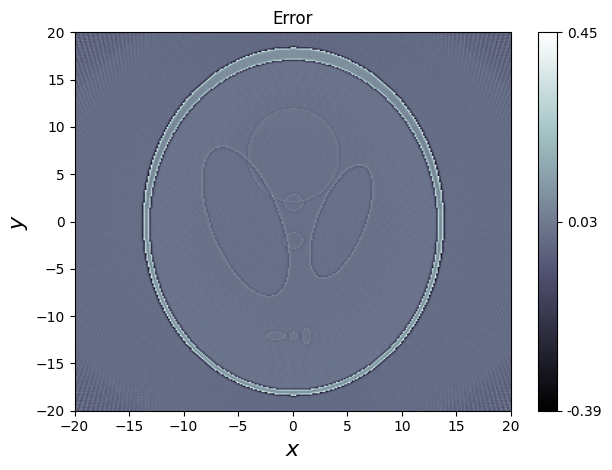

In [4]:
"""
Example using a filtered back-projection (FBP) in fan beam using `fbp_op`.

Note that the FBP is only approximate in this geometry, but still gives a
decent reconstruction that can be used as an initial guess in more complicated
methods.
"""

import numpy as np
import odl


# --- Set up geometry of the problem --- #


# Reconstruction space: discretized functions on the cube
# [-20, 20]^2 with 300 samples per dimension.
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300],
    dtype='float32')

# Make a circular cone beam geometry with flat detector
# Angles: uniformly spaced, n = 360, min = 0, max = 2 * pi
angle_partition = odl.uniform_partition(0, 2 * np.pi, 360)
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.uniform_partition(-60, 60, 512)
# Geometry with large fan angle
geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=40, det_radius=40)


# --- Create Filtered Back-projection (FBP) operator --- #


# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

# Create FBP operator using utility function
# We select a Hann filter, and only use the lowest 80% of frequencies to avoid
# high frequency noise.
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=0.8)


# --- Show some examples --- #


# Create a discrete Shepp-Logan phantom (modified version)
phantom = odl.phantom.shepp_logan(reco_space, modified=True)

# Create projection data by calling the ray transform on the phantom
proj_data = ray_trafo(phantom)

# Calculate filtered back-projection of data
fbp_reconstruction = fbp(proj_data)

# Shows a slice of the phantom, projections, and reconstruction
phantom.show(title='Phantom')
proj_data.show(title='Projection Data (Sinogram)')
fbp_reconstruction.show(title='Filtered Back-projection')
(phantom - fbp_reconstruction).show(title='Error', force_show=True)

torch.uint8
torch.float64
ray adjoint RayBackProjection
bp adjint RayTransform


c:\Users\salom\anaconda3\envs\KEX\lib\site-packages\odl\tomo\backends\astra_cpu.py:318: RuntimeWarning: The 'astra_cpu' backend may be too slow for volumes of this size. Consider using 'astra_cuda' if your machine has an Nvidia GPU.
  warnings.warn(


projection took 8.003539562225342 s
projectiion took  7.706264019012451
MSE odl: tensor(0.0111)
MSE g: tensor(0.0055, dtype=torch.float64)


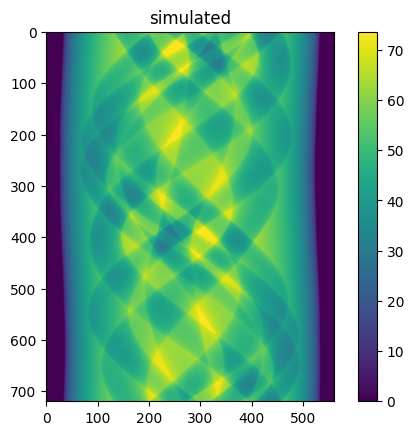

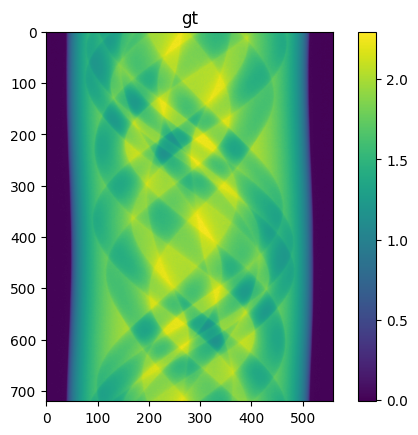

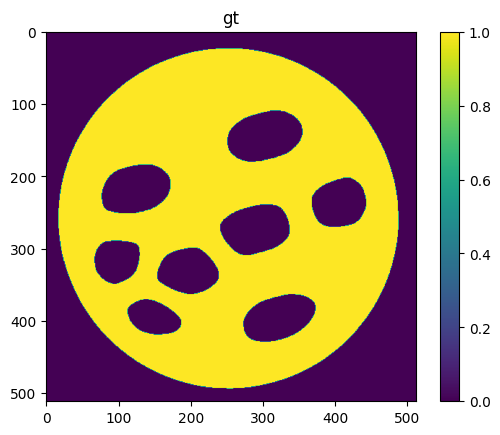

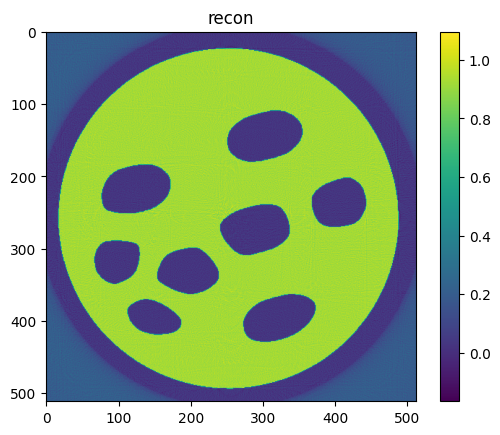

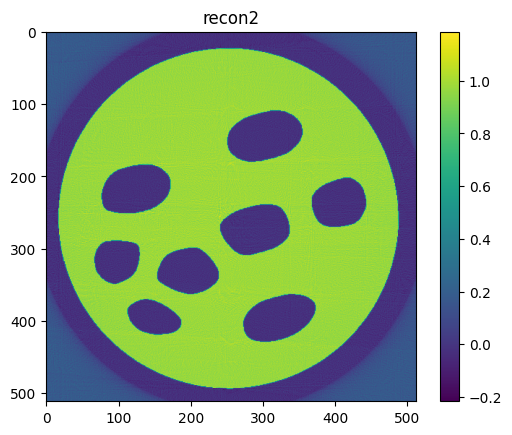

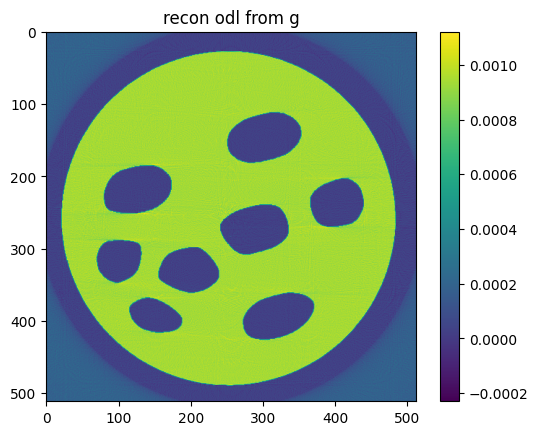

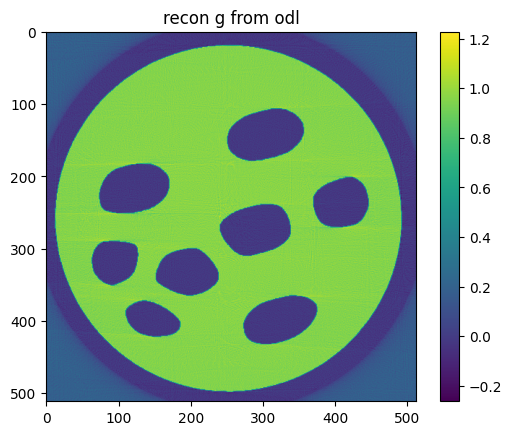

In [10]:
import torch
import odl
import numpy as np
import odl.contrib.torch as odl_torch
import matplotlib.pyplot as plt
import time
import sys
import os
from pathlib import Path
SRC = os.path.abspath("..")
if not SRC in sys.path:
    sys.path.append(SRC)
from geometries.fanbeam_geometry import FlatFanBeamGpeometry

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phantoms = torch.stack(torch.load("../../data/HTC2022/HTCTestPhantomsFull.pt"))[:5].to(DEVICE)
data = torch.stack(torch.load("../../data/HTC2022/HTCTestDataFull.pt"))[:5].to(DEVICE)

print(phantoms.dtype)
print(data.dtype)

reco_space = odl.uniform_discr(
    min_pt=[-40, -40], max_pt=[40, 40], shape=[512, 512],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 720)
detector_partition = odl.uniform_partition(-56, 56, 560)
geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=410.66, det_radius=143.08)

g = FlatFanBeamGeometry(720, 560, 410.66, 543.74, 112, [-40,40, -40, 40], [512, 512])
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='ram-lak', frequency_scaling=1.0)

Ray = odl_torch.OperatorModule(ray_trafo)
print("ray adjoint", ray_trafo.adjoint)
print("bp adjint", ray_trafo.adjoint.adjoint)
bp = odl_torch.OperatorModule(ray_trafo.adjoint)
FBP = odl_torch.OperatorModule(fbp)

start = time.time()
sinos = Ray(phantoms)
print("projection took", time.time()-start,"s")
start = time.time()
sinos2 = g.project_forward(phantoms)
print("projectiion took ", time.time()-start)
recons = FBP(sinos)*1e3
recons2 = g.project_backward(g.inverse_fourier_transform(g.fourier_transform(sinos2*g.jacobian_det)*g.ram_lak_filter()/2))
recons21 = FBP(sinos2)
recons12 = g.fbp_reconstruct(sinos)


print("MSE odl:", torch.mean((recons-phantoms)**2))
print("MSE g:", torch.mean((recons2-phantoms)**2))

look_at_ind = 2

plt.imshow(sinos[look_at_ind].cpu())
plt.title("simulated")
plt.colorbar()
plt.show()
plt.imshow(data[look_at_ind].cpu())
plt.title("gt")
plt.colorbar()
plt.show()
plt.imshow(phantoms[look_at_ind].cpu())
plt.colorbar()
plt.title("gt")
plt.show()
plt.imshow(recons[look_at_ind].cpu())
plt.colorbar()
plt.title("recon")
plt.show()
plt.title("recon2")
plt.imshow(recons2[look_at_ind].cpu())
plt.colorbar()
plt.show()
plt.title("recon odl from g")
plt.imshow(recons21[look_at_ind].cpu())
plt.colorbar()
plt.show()
plt.title("recon g from odl")
plt.imshow(recons12[look_at_ind].cpu())
plt.colorbar()
plt.show()








torch.Size([500, 256, 256])


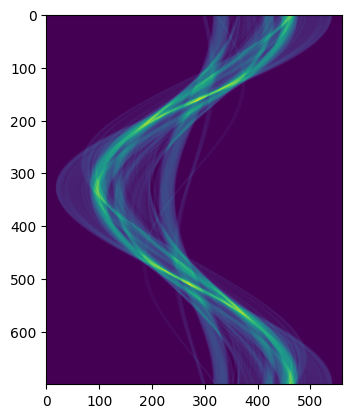

In [10]:
phantoms = torch.load("../../data/kits_phantoms_256.pt")[:500, 0]
print(phantoms.shape)


reco_space = odl.uniform_discr(
    min_pt=[-1.0, -1.0], max_pt=[1.0, 1.0], shape=[256, 256],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 700)
detector_partition = odl.uniform_partition(-1.0, 1.0, 560)

geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=6.0, det_radius=4.0)
# --- Create Filtered Back-projection (FBP) operator --- #

ray_trafo = odl.tomo.RayTransform(reco_space, geometry)
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=0.8)

Ray = odl_torch.OperatorModule(ray_trafo)

# geometry = FlatFanBeamGeometry(720, 560, 410.66, 543.74, 112, [-40,40, -40, 40], [512, 512])
# geometry = FlatFanBeamGeometry(700, 560, 6.0, 10.0, 2.0, [-1.0,1.0, -1.0, 1.0], [256, 256])
# plt.imshow(phantoms[0].cpu())
# plt.show()
start = time.time()
sinos = Ray(phantoms)

plt.imshow(sinos[2].cpu())
plt.show()

In [18]:
ray_trafo.range.cell_volume

0.001742908545680884

In [19]:
ray_trafo

RayTransform: uniform_discr([-40., -40.], [ 40.,  40.], (512, 512), dtype='float32') -> uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
)

In [22]:
fbp

OperatorComp(RayBackProjection: uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
) -> uniform_discr([-40., -40.], [ 40.,  40.], (512, 512), dtype='float32'), OperatorComp(OperatorRightVectorMult(OperatorComp(ResizingOperator: uniform_discr(
    [  -0., -112.], [   6.28318531,  111.8       ], (721, 1119),
    dtype='float32'
) -> uniform_discr(
    [  0., -56.], [  6.28318531,  56.        ], (721, 560),
    dtype='float32'
), FourierTransformInverse: DiscretizedSpace(
    uniform_partition([ -0.   , -15.722], [ 6.2832, -0.014 ], (721, 560), nodes_on_bdry=(False, (False, True))),
    cn((721, 560), dtype='complex64', weighting=0.0002447)
) -> uniform_discr(
    [  -0., -112.], [   6.28318531,  111.8       ], (721, 1119),
    dtype='float32'
)), DiscretizedSpace(
    uniform_partition([ -0.   , -15.722], [ 6.2832, -0.014 ], (721, 560), nodes_on_bdry=(False, (False, True))),
    cn((721, 560), dtype='complex64', weighting=0.0002447)
).element(
